# Experiments Adversarial

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

import torch
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
from torch.distributions.mixture_same_family import MixtureSameFamily


from adversarial_sb.adversarial_ipfp import AdversarialIPFPTrainer
from adversarial_sb.models import SimpleConditional, SimpleDiscriminator, Conditional, Discriminator
from adversarial_sb.data import OneVariateDataset, MoonCircleDataset, ImageDataset
from adversarial_sb.utils import visualize_losses, visualize_gan, visualize_sb, visualize_gan_images, visualize_sb_images


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# One variate

## One mode

In [42]:
# Marginals
marginal_x = Normal(0, 1)
marginal_y = Normal(5, 1)

# Trainer and dataloader parameters
batch_size = 128
dataset = OneVariateDataset(5_000, marginal_x, marginal_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [43]:
# Models parameters
data_dim = 1
hidden_dims = [128, 64, 32]
conditional_q_fixed = SimpleConditional(data_dim, hidden_dims).to(device)

# Init conditional
init_params = {
    'epochs': 120,
    'loader': dataloader,
    'gamma': 2.,
    'lr_disc': 1e-4, 
    'lr_gen': 4e-5,    
}
losses = conditional_q_fixed.init_conditional(**init_params)

  0%|          | 0/120 [00:00<?, ?it/s]

gen Loss: 1.0626220792531966, disc Real Loss: 0.9059148475527763, disc Fake Loss: 0.43478749245405196
gen Loss: 0.9727840945124626, disc Real Loss: 0.46307135820388795, disc Fake Loss: 0.8127106741070748
gen Loss: 0.8968573868274688, disc Real Loss: 0.6314527466893196, disc Fake Loss: 0.5403671972453594
gen Loss: 0.8571954935789108, disc Real Loss: 0.6503980681300163, disc Fake Loss: 0.5592653840780258
gen Loss: 0.8474853530526161, disc Real Loss: 0.6797712132334709, disc Fake Loss: 0.5756142422556877
gen Loss: 0.7736243054270744, disc Real Loss: 0.6582579344511033, disc Fake Loss: 0.6257517904043197


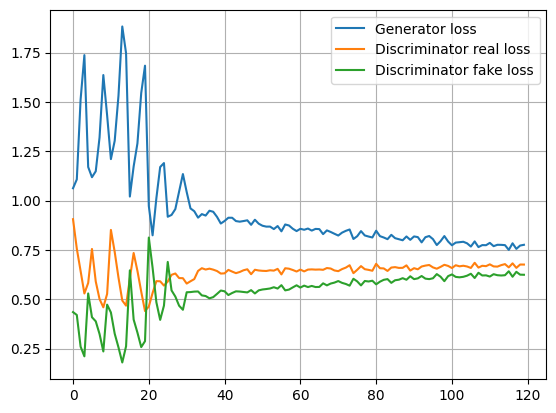

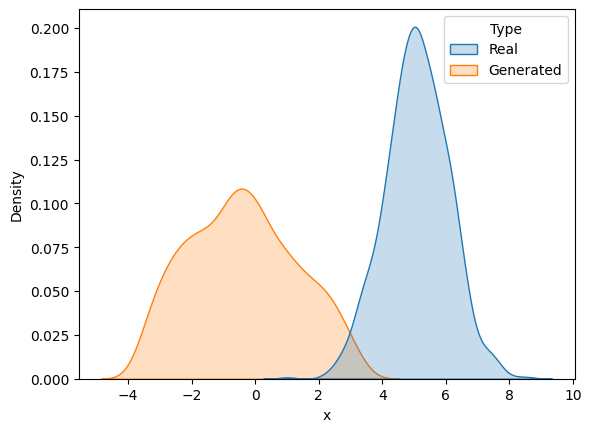

In [44]:
conditional_q_fixed.to('cpu')

visualize_losses(losses, conditional_q_fixed.loss_titles, inner_steps=1)
visualize_gan(conditional_q_fixed, dataset)

In [48]:
from copy import deepcopy

discriminator_backward = SimpleDiscriminator(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleDiscriminator(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 4e-5, 'backward': 4e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.001,
    device=device
)

epochs = 80
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/80 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: -0.28373, disc_b_fixed: -0.23165, disc_b_training: -0.28385
Backward cond_p: 0.99555, disc_b_fixed: -0.31146, disc_b_training: 0.99489
Backward cond_p: 1.66834, disc_b_fixed: -0.26791, disc_b_training: 1.66830
Backward cond_p: 1.99952, disc_b_fixed: -0.17066, disc_b_training: 1.99945
Backward cond_p: 2.08107, disc_b_fixed: -0.11206, disc_b_training: 2.08110
Forward cond_q: 0.11598, disc_f_fixed: -0.56669, disc_f_training: 0.11587
Forward cond_q: 0.84751, disc_f_fixed: -0.33146, disc_f_training: 0.84384
Forward cond_q: 1.55291, disc_f_fixed: -0.27755, disc_f_training: 1.56263
Forward cond_q: 2.16279, disc_f_fixed: -0.20048, disc_f_training: 2.16318
Forward cond_q: 2.35231, disc_f_fixed: -0.21499, disc_f_training: 2.35589
======= Epoch 1 =======
Backward cond_p: 2.02779, disc_b_fixed: -0.31762, disc_b_training: 2.02537
Backward cond_p: 2.03402, disc_b_fixed: -0.17846, disc_b_training: 2.03334
Backward cond_p: 2.05206, disc_b_fixed: -0.16846, disc_

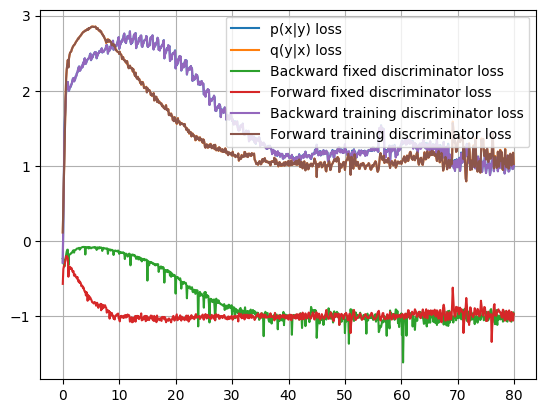

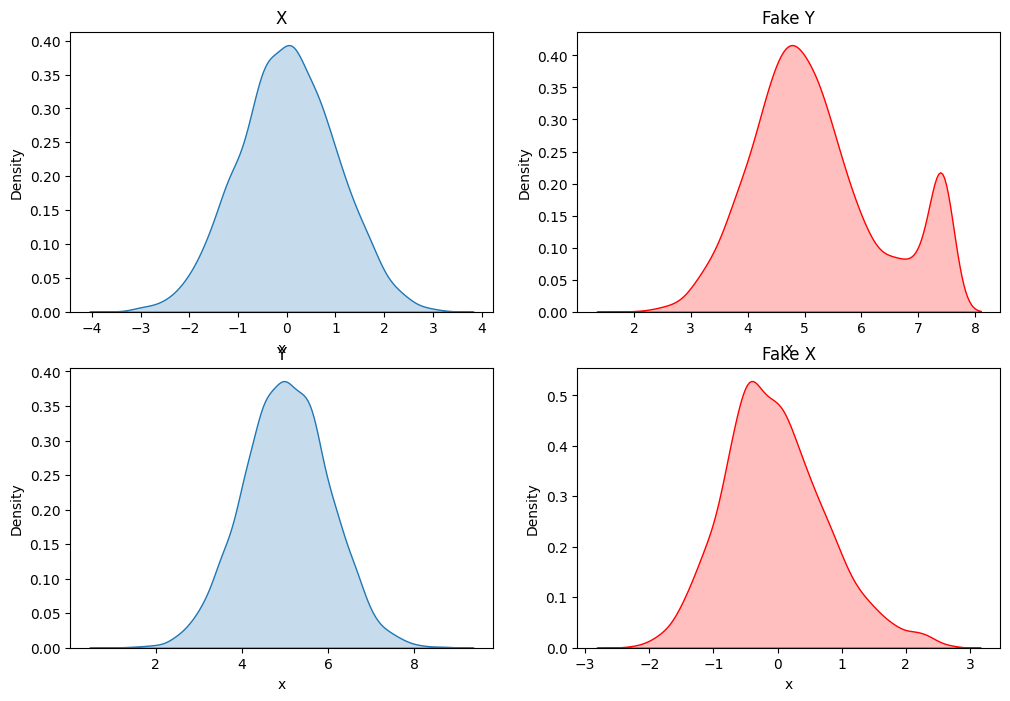

In [50]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

## Two modes

In [77]:
# Marginals
marginal_x = Normal(0, 1)
marginal_y = MixtureSameFamily(
    Categorical(torch.tensor([0.5, 0.5], dtype=torch.float)), 
    Normal(torch.tensor([20, -20], dtype=torch.float), torch.tensor([0.5, 0.5], dtype=torch.float))
)

# Trainer and dataloader parameters
batch_size = 128
dataset = OneVariateDataset(5_000, marginal_x, marginal_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [94]:
# Models parameters
data_dim = 1
hidden_dims = [128, 64, 32]
conditional_q_fixed = SimpleConditional(data_dim, hidden_dims).to(device)

# Init conditional
init_params = {
    'epochs': 500,
    'loader': dataloader,
    'gamma': 10.,
    'lr_disc': 4e-4, 
    'lr_gen': 1e-4,    
}
losses = conditional_q_fixed.init_conditional(**init_params)

  0%|          | 0/500 [00:00<?, ?it/s]

gen Loss: 1.298103152215481, disc Real Loss: 0.4145555146038532, disc Fake Loss: 0.38843945004045966
gen Loss: 1.7019202351570129, disc Real Loss: 0.37901718616485597, disc Fake Loss: 0.21125964783132076
gen Loss: 1.5336872577667235, disc Real Loss: 0.4200971633195877, disc Fake Loss: 0.24885364957153797
gen Loss: 1.4259715914726256, disc Real Loss: 0.46350972577929495, disc Fake Loss: 0.2818678684532642
gen Loss: 1.3104306608438492, disc Real Loss: 0.4831961952149868, disc Fake Loss: 0.3185454450547695
gen Loss: 1.210949918627739, disc Real Loss: 0.5219386301934719, disc Fake Loss: 0.36787889450788497
gen Loss: 1.1649432450532913, disc Real Loss: 0.5422909758985043, disc Fake Loss: 0.376402722299099
gen Loss: 1.1648034185171128, disc Real Loss: 0.5480114534497261, disc Fake Loss: 0.4109528973698616
gen Loss: 1.0537575215101243, disc Real Loss: 0.5847226716578007, disc Fake Loss: 0.4389780849218369
gen Loss: 0.9755503803491592, disc Real Loss: 0.5751327835023403, disc Fake Loss: 0.4873

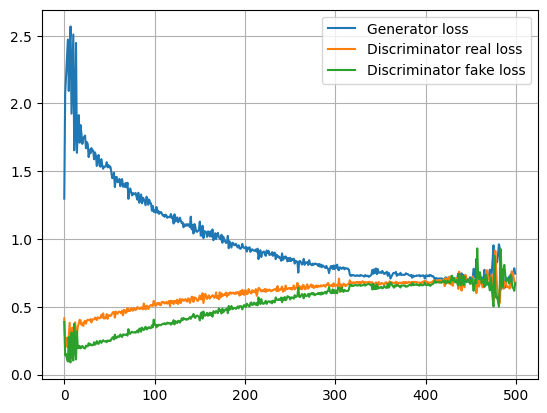

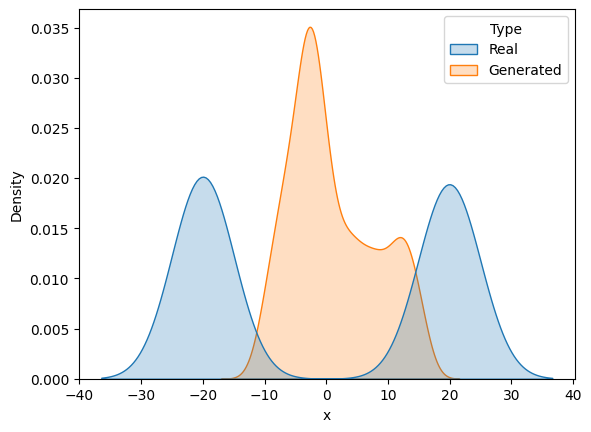

In [95]:
conditional_q_fixed.to('cpu')

visualize_losses(losses, conditional_q_fixed.loss_titles, inner_steps=1)
visualize_gan(conditional_q_fixed, dataset)

In [96]:
from copy import deepcopy

discriminator_backward = SimpleDiscriminator(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleDiscriminator(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 4e-5, 'backward': 4e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.001,
    device=device
)

epochs = 100
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.06882, disc_b_fixed: -0.38241, disc_b_training: 0.06879
Backward cond_p: 0.98676, disc_b_fixed: -0.71167, disc_b_training: 0.98666
Backward cond_p: 1.46368, disc_b_fixed: -0.64175, disc_b_training: 1.46345
Backward cond_p: 1.90606, disc_b_fixed: -0.48748, disc_b_training: 1.90594
Backward cond_p: 2.20280, disc_b_fixed: -0.28178, disc_b_training: 2.20246
Forward cond_q: 0.23523, disc_f_fixed: -0.52472, disc_f_training: 0.23874
Forward cond_q: 0.98505, disc_f_fixed: -0.78373, disc_f_training: 0.98823
Forward cond_q: 1.17830, disc_f_fixed: -0.69772, disc_f_training: 1.18277
Forward cond_q: 1.40036, disc_f_fixed: -0.55383, disc_f_training: 1.38292
Forward cond_q: 1.66683, disc_f_fixed: -0.34991, disc_f_training: 1.66477
======= Epoch 1 =======
Backward cond_p: 2.44365, disc_b_fixed: -0.23275, disc_b_training: 2.44257
Backward cond_p: 2.45283, disc_b_fixed: -0.23858, disc_b_training: 2.44970
Backward cond_p: 2.42948, disc_b_fixed: -0.23914, disc_b_

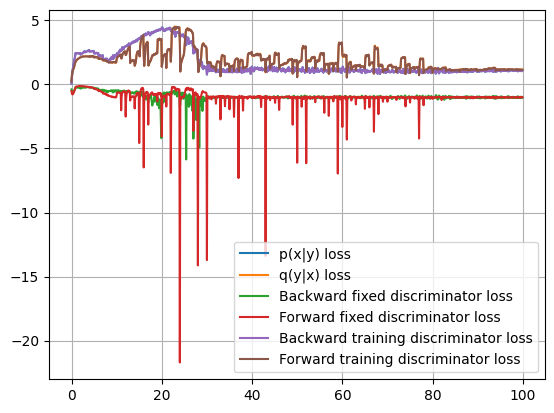

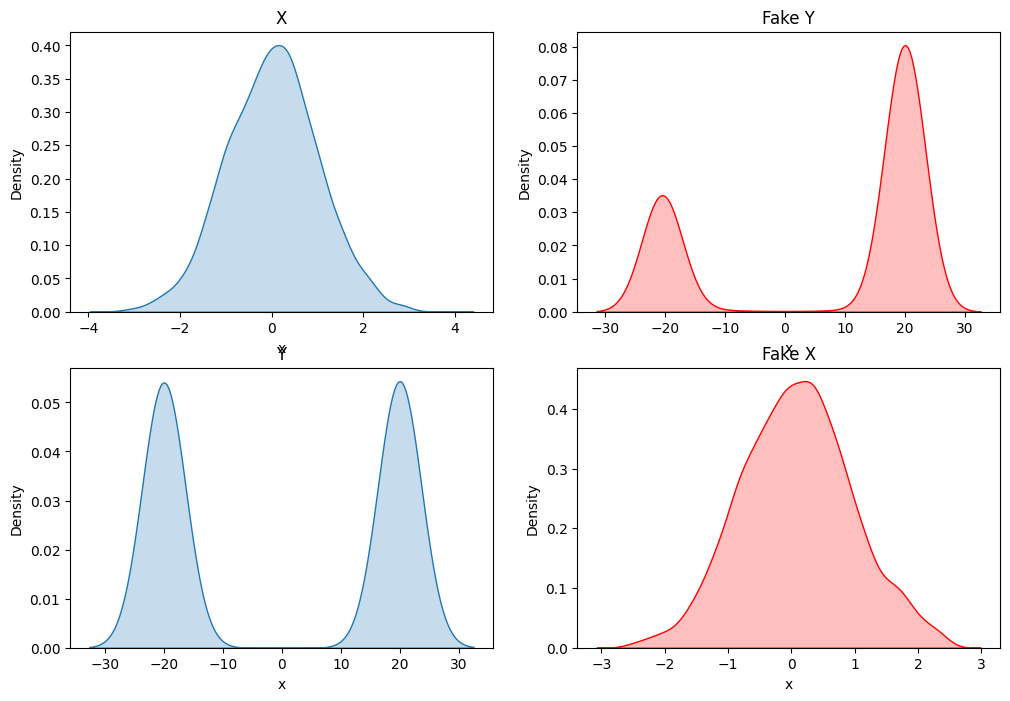

In [97]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

In [98]:
from copy import deepcopy

discriminator_backward = SimpleDiscriminator(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleDiscriminator(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 4e-5, 'backward': 4e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.001,
    device=device
)

epochs = 200
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.49170, disc_b_fixed: -0.56104, disc_b_training: 0.49169
Backward cond_p: 1.22511, disc_b_fixed: -0.81365, disc_b_training: 1.22504
Backward cond_p: 1.77094, disc_b_fixed: -0.65629, disc_b_training: 1.77089
Backward cond_p: 2.13138, disc_b_fixed: -0.46380, disc_b_training: 2.13141
Backward cond_p: 2.38483, disc_b_fixed: -0.29647, disc_b_training: 2.38470
Forward cond_q: 0.47034, disc_f_fixed: -0.59313, disc_f_training: 0.46639
Forward cond_q: 1.04808, disc_f_fixed: -0.73477, disc_f_training: 1.04901
Forward cond_q: 1.33726, disc_f_fixed: -0.63250, disc_f_training: 1.32820
Forward cond_q: 1.61513, disc_f_fixed: -0.35247, disc_f_training: 1.61887
Forward cond_q: 1.85230, disc_f_fixed: -0.12371, disc_f_training: 1.85272
======= Epoch 1 =======
Backward cond_p: 2.58021, disc_b_fixed: -0.17707, disc_b_training: 2.57999
Backward cond_p: 2.59820, disc_b_fixed: -0.16780, disc_b_training: 2.59848
Backward cond_p: 2.61076, disc_b_fixed: -0.17046, disc_b_

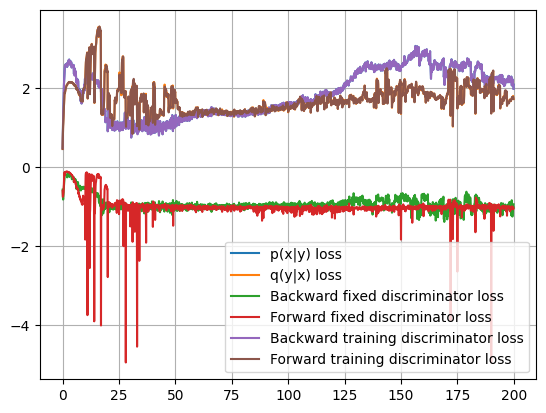

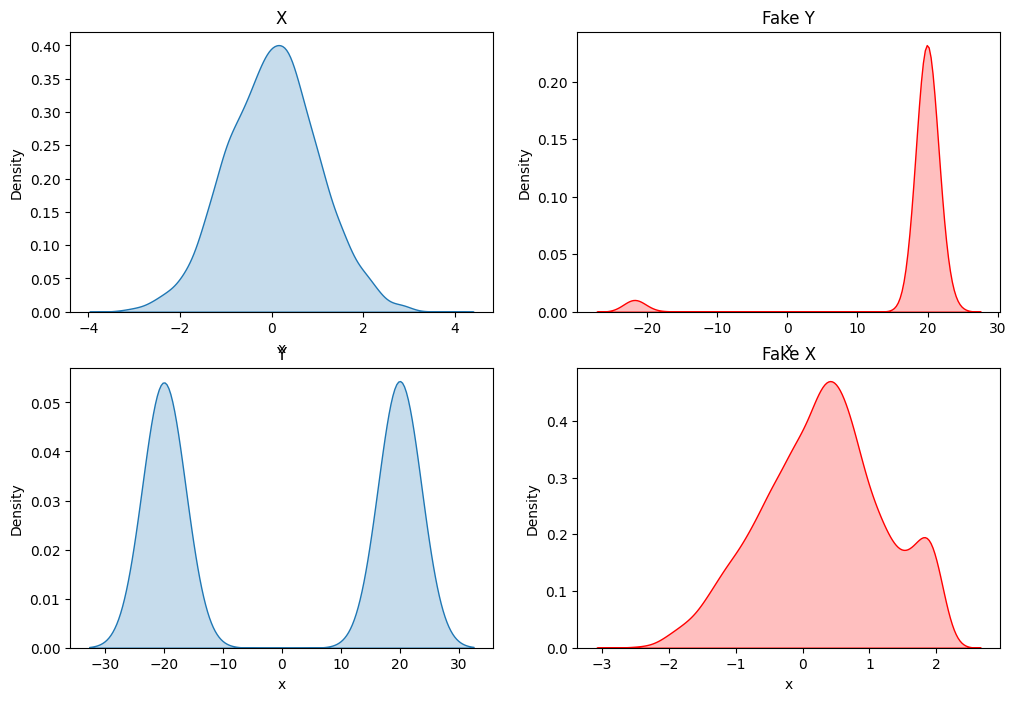

In [99]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

In [108]:
from copy import deepcopy

discriminator_backward = SimpleDiscriminator(data_dim, hidden_dims).to(device)
discriminator_forward = SimpleDiscriminator(data_dim, hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 5e-5, 'backward': 5e-5},
    lr_gen={'forward': 2e-5, 'backward': 2e-5},
    # clip=0.001,
    device=device
)

epochs = 150
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.45783, disc_b_fixed: -0.64404, disc_b_training: 0.45779
Backward cond_p: 1.14569, disc_b_fixed: -0.77818, disc_b_training: 1.14552
Backward cond_p: 1.61054, disc_b_fixed: -0.51371, disc_b_training: 1.61032
Backward cond_p: 1.69893, disc_b_fixed: -0.46949, disc_b_training: 1.69885
Backward cond_p: 1.78507, disc_b_fixed: -0.41947, disc_b_training: 1.78381
Forward cond_q: 0.20120, disc_f_fixed: -0.50091, disc_f_training: 0.20646
Forward cond_q: 1.16796, disc_f_fixed: -0.72731, disc_f_training: 1.17349
Forward cond_q: 1.56670, disc_f_fixed: -0.55274, disc_f_training: 1.55276
Forward cond_q: 1.82607, disc_f_fixed: -0.23926, disc_f_training: 1.84101
Forward cond_q: 1.97565, disc_f_fixed: -0.15433, disc_f_training: 1.97312
======= Epoch 1 =======
Backward cond_p: 1.94056, disc_b_fixed: -0.66301, disc_b_training: 1.92121
Backward cond_p: 2.12373, disc_b_fixed: -0.46204, disc_b_training: 2.11118
Backward cond_p: 2.12963, disc_b_fixed: -0.48058, disc_b_

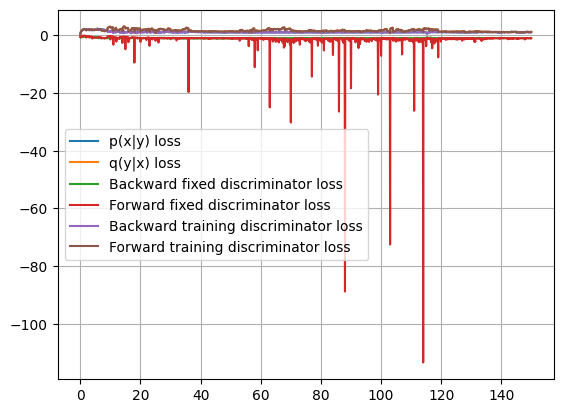

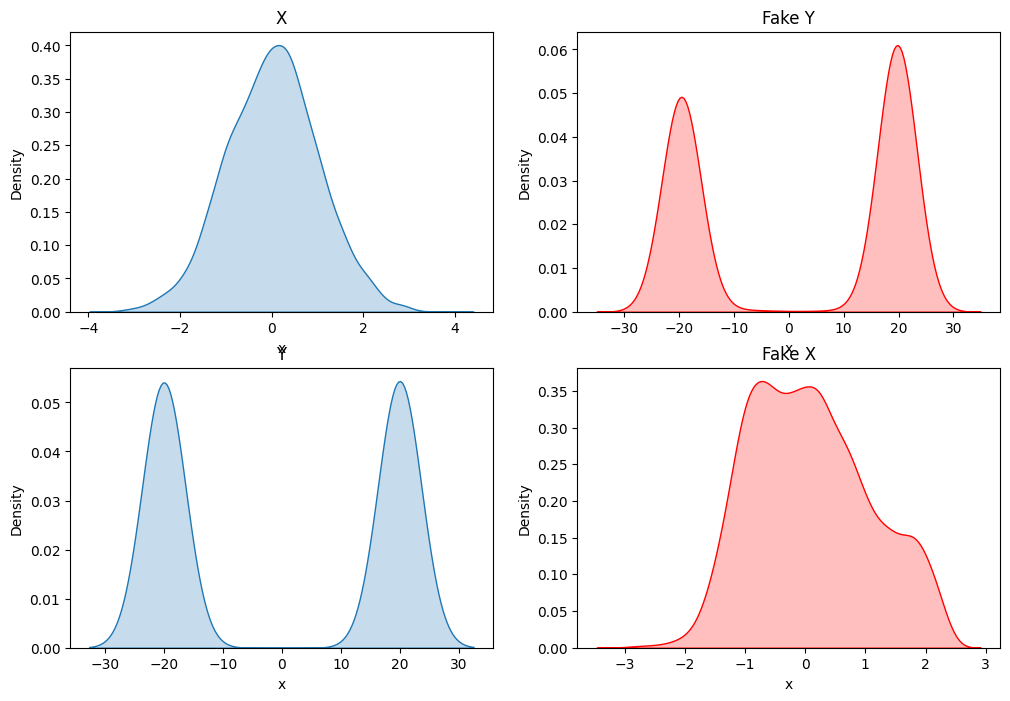

In [109]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

# Two variate

In [24]:
batch_size = 512

dataset = MoonCircleDataset(5_000)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [47]:
# Models parameters
data_dim = 2
hidden_dims = [128, 64, 32]

conditional_q_fixed = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)


init_params = {
    'epochs': 180,
    'loader': dataloader,
    'gamma': 2.,
    'lr_disc': 8e-5, 
    'lr_gen': 2e-5,    
}
losses = conditional_q_fixed.init_conditional(**init_params)

  0%|          | 0/180 [00:00<?, ?it/s]

gen Loss: 0.6321607828140259, disc Real Loss: 0.5758085429668427, disc Fake Loss: 0.7823592603206635
gen Loss: 1.8276821732521058, disc Real Loss: 0.3350613534450531, disc Fake Loss: 0.20267084389925002
gen Loss: 1.7795056223869323, disc Real Loss: 0.49350050985813143, disc Fake Loss: 0.2112646594643593
gen Loss: 1.6123677134513854, disc Real Loss: 0.5395868748426438, disc Fake Loss: 0.23394104987382888
gen Loss: 1.4811882853507996, disc Real Loss: 0.513703441619873, disc Fake Loss: 0.2660961925983429
gen Loss: 1.3717355847358703, disc Real Loss: 0.4986345946788788, disc Fake Loss: 0.3028899997472763
gen Loss: 1.3314987897872925, disc Real Loss: 0.5060494989156723, disc Fake Loss: 0.31931684017181394
gen Loss: 1.3167577147483827, disc Real Loss: 0.5217860072851181, disc Fake Loss: 0.318782839179039
gen Loss: 1.2820518136024475, disc Real Loss: 0.531369286775589, disc Fake Loss: 0.33523963689804076


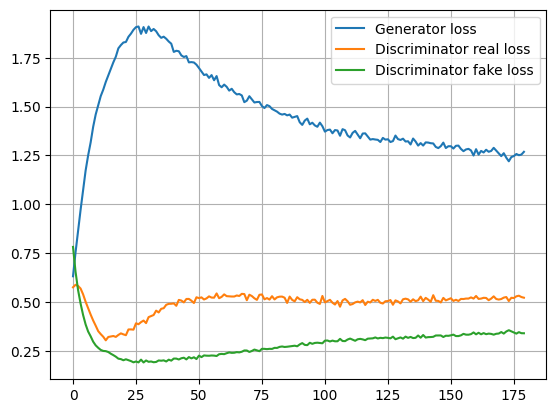

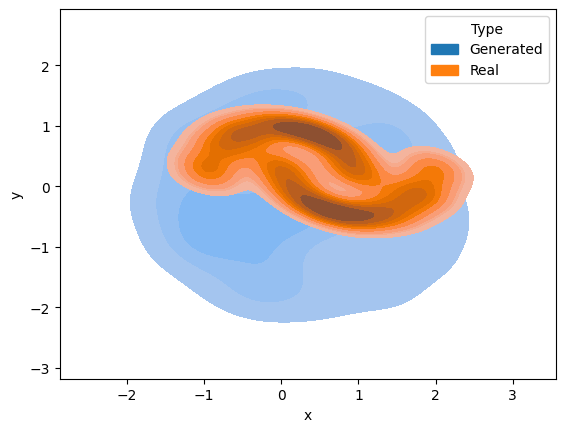

In [48]:
conditional_q_fixed.cpu()

visualize_losses(losses, conditional_q_fixed.loss_titles)
visualize_gan(conditional_q_fixed, dataset)

In [18]:
from copy import deepcopy

discriminator_backward = SimpleDiscriminator(data_dim, hidden_dims=hidden_dims).to(device)
discriminator_forward = SimpleDiscriminator(data_dim, hidden_dims=hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 4e-5, 'backward': 4e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.01,
    device=device
)

losses = trainer.train(100, dataloader, inner_steps=10)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.71409, disc_b_fixed: -0.45321, disc_b_training: 0.70951
Backward cond_p: 1.46529, disc_b_fixed: -0.45733, disc_b_training: 1.46493
Backward cond_p: 1.84572, disc_b_fixed: -0.39079, disc_b_training: 1.84407
Backward cond_p: 2.05401, disc_b_fixed: -0.32675, disc_b_training: 2.05063
Backward cond_p: 2.24875, disc_b_fixed: -0.29744, disc_b_training: 2.24753
Backward cond_p: 2.36470, disc_b_fixed: -0.25398, disc_b_training: 2.36663
Backward cond_p: 2.44393, disc_b_fixed: -0.24461, disc_b_training: 2.44469
Backward cond_p: 2.53488, disc_b_fixed: -0.26469, disc_b_training: 2.53304
Forward cond_q: 0.11741, disc_f_fixed: -0.41250, disc_f_training: 0.11212
Forward cond_q: 0.91238, disc_f_fixed: -0.54272, disc_f_training: 0.91149
Forward cond_q: 1.40762, disc_f_fixed: -0.47704, disc_f_training: 1.42326
Forward cond_q: 1.63473, disc_f_fixed: -0.38639, disc_f_training: 1.62564
Forward cond_q: 1.67497, disc_f_fixed: -0.34761, disc_f_training: 1.69021
Forwar

KeyboardInterrupt: 

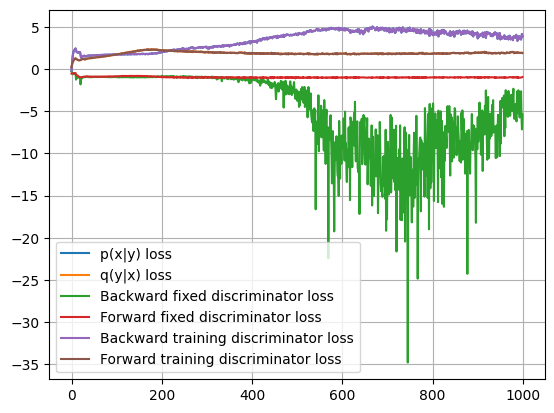

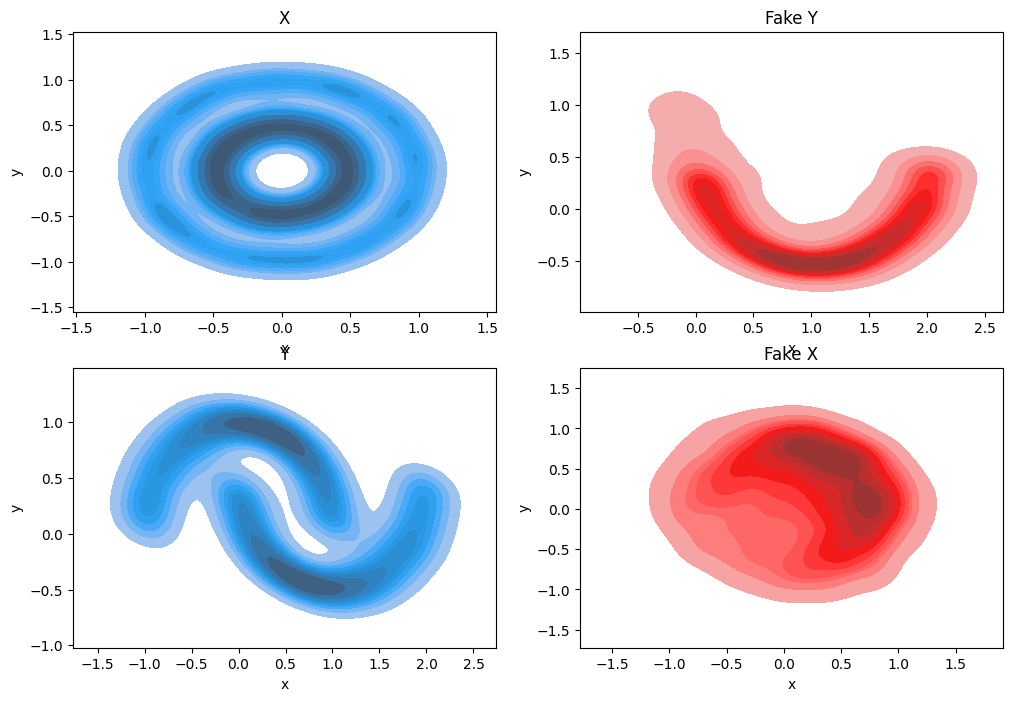

In [ ]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles)
visualize_sb(conditional_p, conditional_q, dataset, num_samples=len(dataset))

In [66]:
from copy import deepcopy

discriminator_backward = SimpleDiscriminator(data_dim, hidden_dims=hidden_dims).to(device)
discriminator_forward = SimpleDiscriminator(data_dim, hidden_dims=hidden_dims).to(device)

conditional_p = SimpleConditional(data_dim, hidden_dims=hidden_dims).to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 8e-5, 'backward': 8e-5},
    lr_gen={'forward': 2e-5, 'backward': 2e-5},
    # clip=0.01,
    device=device
)

epochs = 100
inner_steps = 20
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.11204, disc_b_fixed: -0.42253, disc_b_training: 0.11132
Backward cond_p: 0.72299, disc_b_fixed: -0.65339, disc_b_training: 0.71927
Backward cond_p: 1.16316, disc_b_fixed: -0.85703, disc_b_training: 1.16482
Backward cond_p: 1.37077, disc_b_fixed: -0.92515, disc_b_training: 1.36902
Backward cond_p: 1.47506, disc_b_fixed: -0.92282, disc_b_training: 1.46993
Backward cond_p: 1.58540, disc_b_fixed: -0.86560, disc_b_training: 1.58167
Backward cond_p: 1.71276, disc_b_fixed: -0.84443, disc_b_training: 1.70446
Backward cond_p: 1.73308, disc_b_fixed: -0.85827, disc_b_training: 1.73241
Backward cond_p: 1.70971, disc_b_fixed: -0.86281, disc_b_training: 1.69383
Backward cond_p: 1.71754, disc_b_fixed: -0.83207, disc_b_training: 1.70053
Forward cond_q: 0.52907, disc_f_fixed: -0.71726, disc_f_training: 0.53041
Forward cond_q: 0.75753, disc_f_fixed: -0.70249, disc_f_training: 0.75607
Forward cond_q: 0.93939, disc_f_fixed: -0.71899, disc_f_training: 0.94045
Forw

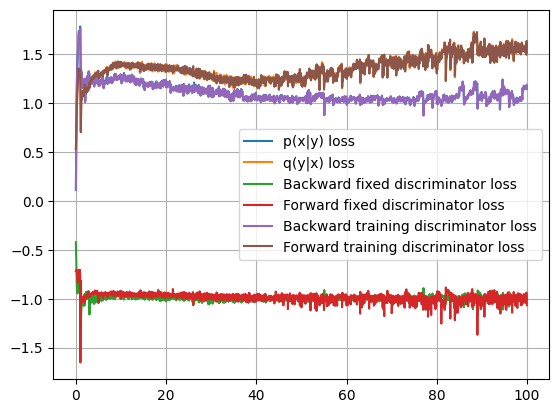

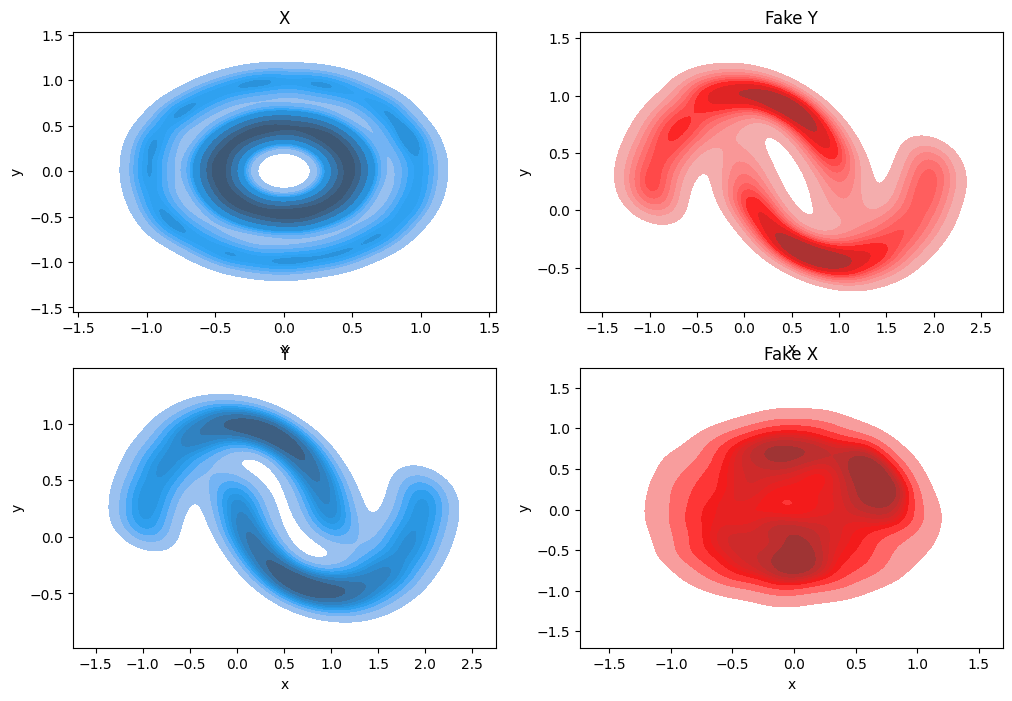

In [69]:
conditional_q.to('cpu')
conditional_p.to('cpu')

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb(conditional_p, conditional_q, dataset)

# Images: Monet $\rightarrow$ Photo

In [2]:
batch_size = 8

dataset = ImageDataset('../data/')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [10]:
# Models parameters
conditional_q_fixed = Conditional().to(device)


init_params = {
    'epochs': 100,
    'loader': dataloader,
    'gamma': 1.,
    'lr_disc': 4e-4, 
    'lr_gen': 1e-4,    
}
losses = conditional_q_fixed.init_conditional(**init_params)

  0%|          | 0/100 [00:00<?, ?it/s]

gen Loss: 0.7595004048198462, disc Real Loss: 0.6525393575429916, disc Fake Loss: 0.6529616061598063
gen Loss: 3.9638833329081535, disc Real Loss: 0.0493336723302491, disc Fake Loss: 0.04108395311050117
gen Loss: 4.294227369129658, disc Real Loss: 0.030052935879211873, disc Fake Loss: 0.0240094069740735
gen Loss: 5.451030567288399, disc Real Loss: 0.00832566867757123, disc Fake Loss: 0.007119295172742568
gen Loss: 5.762684464454651, disc Real Loss: 0.007684566167881712, disc Fake Loss: 0.006605953654798213


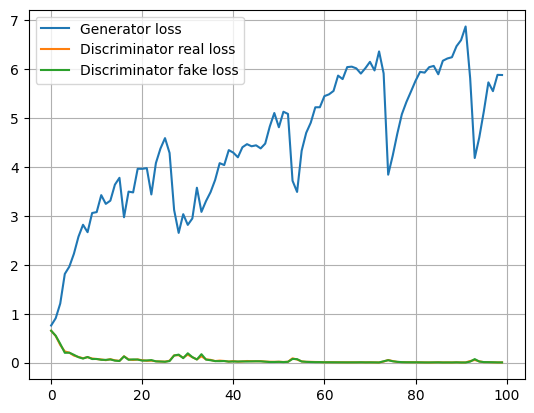

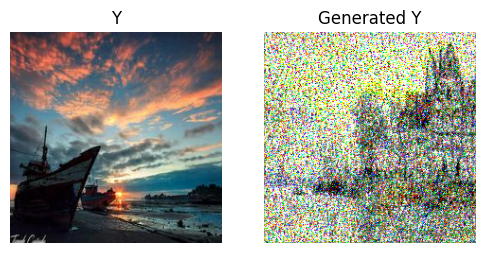

In [11]:
conditional_q_fixed.cpu().eval()

visualize_losses(losses, conditional_q_fixed.loss_titles)
visualize_gan_images(conditional_q_fixed, dataset)

In [12]:
from copy import deepcopy

discriminator_backward = Discriminator(6).to(device)
discriminator_forward = Discriminator(6).to(device)

conditional_q_fixed.train()
conditional_p = Conditional().to(device)
conditional_q = deepcopy(conditional_q_fixed).to(device)

trainer = AdversarialIPFPTrainer(
    conditional_p,
    conditional_q,
    discriminator_backward,
    discriminator_forward,
    lr_disc={'forward': 1e-5, 'backward': 1e-5},
    lr_gen={'forward': 1e-5, 'backward': 1e-5},
    # clip=0.01,
    device=device
)


epochs = 10
inner_steps = 10
losses = trainer.train(epochs, dataloader, inner_steps=inner_steps)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

======= Epoch 0 =======
Backward cond_p: 0.23162, disc_b_fixed: -0.38491, disc_b_training: 0.22724
Backward cond_p: 1.35752, disc_b_fixed: -0.76457, disc_b_training: 1.35031
Backward cond_p: 1.69102, disc_b_fixed: -0.80395, disc_b_training: 1.67659
Backward cond_p: 2.04076, disc_b_fixed: -0.72797, disc_b_training: 2.03954
Backward cond_p: 2.46174, disc_b_fixed: -0.75619, disc_b_training: 2.43199
Forward cond_q: 0.17320, disc_f_fixed: -0.42767, disc_f_training: 0.17349
Forward cond_q: 1.09943, disc_f_fixed: -0.74151, disc_f_training: 1.09794
Forward cond_q: 1.76956, disc_f_fixed: -0.87303, disc_f_training: 1.76597
Forward cond_q: 2.22223, disc_f_fixed: -0.82701, disc_f_training: 2.20452
Forward cond_q: 2.87954, disc_f_fixed: -0.85306, disc_f_training: 2.87076
======= Epoch 1 =======
Backward cond_p: 2.75831, disc_b_fixed: -0.70554, disc_b_training: 2.75425
Backward cond_p: 3.44960, disc_b_fixed: -0.54784, disc_b_training: 3.44752
Backward cond_p: 4.06650, disc_b_fixed: -0.56418, disc_b_

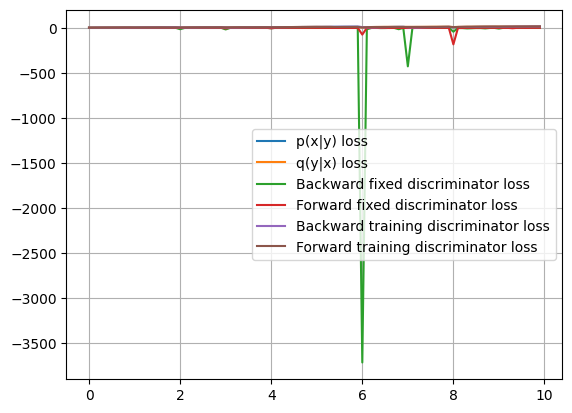

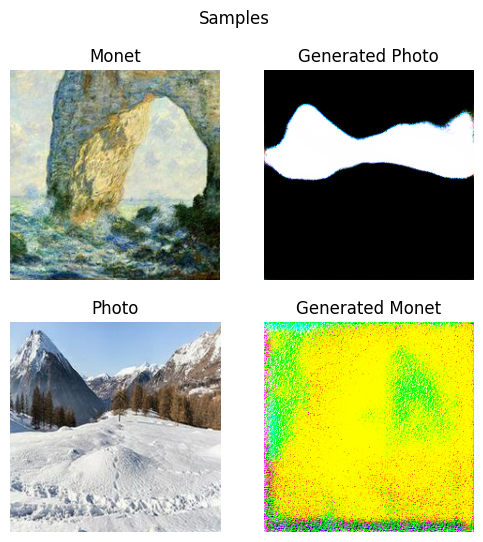

In [20]:
conditional_q.to('cpu')
conditional_p.to('cpu')

conditional_q.eval()
conditional_p.eval()

visualize_losses(losses, trainer.loss_titles, inner_steps=inner_steps)
visualize_sb_images(conditional_q, conditional_p, dataset, x_title='Monet', y_title='Photo')

In [15]:
torch.save(conditional_p.state_dict(), '../models/conditional_p.pt')
torch.save(conditional_q.state_dict(), '../models/conditional_q.pt')

In [12]:
from copy import deepcopy

In [16]:
conditional_p = Conditional()
conditional_p.load_state_dict(torch.load('../models/conditional_p.pt'))

conditional_q = deepcopy(conditional_q_fixed).cpu()
conditional_q.load_state_dict(torch.load('../models/conditional_q.pt'))

<All keys matched successfully>